# Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)

In [1]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

tiktoken version: 0.11.0
torch version: 2.8.0


In [2]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-with-preference.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
import pprint

pprint.pp(data[50])

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


In [4]:
pprint.pp(data[999])

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'.",
 'chosen': "A suitable antonym for 'complicated' would be 'simple'.",
 'rejected': "An antonym of 'complicated' is 'simple'."}


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


In [7]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

### Response:
The correct spelling is 'Occasion.'


In [8]:
possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
The correct spelling is obviously 'Occasion.'


In [9]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [11]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


In [12]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # Initialize lists to hold batch data
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []

    }

    # Determine the longest sequence to set a common padding length
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key])+1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item in the batch
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # Adjust padding according to the common maximum length
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # Set mask for all padding tokens to False
            mask[len(sequence):] = False

            # Set mask for all input tokens to False
            # +2 sets the 2 newline ("\n") tokens before "### Response" to False
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # Final processing
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # Stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key])

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # Move to the specified device
        batch_data[key] = tensor_stack.to(device)

    return batch_data

In [13]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # Put the data directly on a GPU if available
    mask_prompt_tokens=True,  # This is optional
    allowed_max_length=1024   # The supported context length of the model
)

Device: cpu


In [14]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


In [15]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

In [16]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


In [17]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

In [18]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

In [19]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

In [20]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # [0] for the first entry in the batch
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


In [21]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [22]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


In [23]:
print("chosen inputs:", batch["chosen"][0].shape)
print("chosen mask:  ", batch["chosen_mask"][0].shape)

chosen inputs: torch.Size([81])
chosen mask:   torch.Size([81])


In [24]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False])

In [25]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [26]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


In [27]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [28]:
val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [29]:
print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torc

In [30]:
from pathlib import Path
import shutil


finetuned_model_path = Path("gpt2-medium355M-sft.pth")
if not finetuned_model_path.exists():

    # Try finding the model checkpoint locally:
    relative_path = Path("..") / "01_main-chapter-code" / finetuned_model_path
    if relative_path.exists():
        shutil.copy(relative_path, ".")

    # If this notebook is run on Google Colab, get it from a Google Drive folder
    elif "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ:
        from google.colab import drive
        drive.mount("/content/drive")
        google_drive_path = "/content/drive/My Drive/Books/LLMs-From-Scratch/ch07/colab/gpt2-medium355M-sft.pth"  # Readers need to adjust this path
        shutil.copy(google_drive_path, ".")

    else:
        print(
            f"Could not find '{finetuned_model_path}'.\n"
            "Run the `ch07.ipynb` notebook to finetune and save the finetuned model."
        )

In [31]:
finetuned_model_path

PosixPath('gpt2-medium355M-sft.pth')

In [32]:
relative_path

PosixPath('../01_main-chapter-code/gpt2-medium355M-sft.pth')

In [33]:
from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [34]:
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 1024,
 'n_layers': 24,
 'n_heads': 16}

In [35]:
model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

In [36]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [37]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# Alternatively:
# from llms_from_scratch.ch05 (
#     generate,
#     text_to_token_ids,
#     token_ids_to_text
# )

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


In [38]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


In [39]:
policy_model = model

reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        "gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()

policy_model.to(device)
reference_model.to(device);

In [40]:
import torch.nn.functional as F

def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    # DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

In [41]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size,)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

In [42]:
# Sample data
logits = torch.tensor(
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]])  # Shape: (2, 3)
targets = torch.tensor([0, 2])  # Shape: (2,)


# Manual loss using torch.gather
log_softmax_logits = F.log_softmax(logits, dim=1)  # Shape: (2, 3)
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(1), # Shape 2, 1
).squeeze(1)  # Shape: (2,)
manual_loss = -selected_log_probs.mean()  # Averaging over the batch


# PyTorch loss
cross_entropy_loss = F.cross_entropy(logits, targets)

print(manual_loss, cross_entropy_loss)

tensor(1.4185) tensor(1.4185)


In [43]:
log_softmax_logits

tensor([[-0.4170, -1.4170, -2.3170],
        [-2.2200, -0.2200, -2.4200]])

In [44]:
selected_log_probs

tensor([-0.4170, -2.4200])

In [45]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    
    with torch.no_grad():
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

In [46]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

(tensor(0.6931), tensor(0.0009), tensor(0.0002))


In [48]:
len(batch)

5

In [52]:
type(batch)

dict

In [53]:
batch.keys()

dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])

In [54]:
len(batch['prompt'])

8

In [56]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """Apply compute_dpo_loss_batch to a whole data loader"""

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

In [57]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """Compute the DPO loss for the training and validation dataset"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

In [58]:
from previous_chapters import generate_and_print_sample
# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple


def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # Initialize lists to track losses and tokens seen
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        policy_model.train()  # Set model to training mode

        for batch in train_loader:

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

In [59]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

Training loss: 0.6930648207664489
Validation loss: 0.6931374549865723
Train reward margin: 0.0016491834772750734
Val reward margin: 0.00019411337561905386


In [60]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> The input string 'dance' could be classified as a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>> The book is a page-turner.

Model re

In [61]:
import time

start_time = time.time()

torch.manual_seed(123)


optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # value between 0.1 and 0.5
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.692, Val loss 0.693, Train reward margins 0.014, Val reward margins 0.006
Ep 1 (Step 000005): Train loss 0.691, Val loss 0.692, Train reward margins 0.041, Val reward margins 0.033
Ep 1 (Step 000010): Train loss 0.688, Val loss 0.690, Train reward margins 0.104, Val reward margins 0.066
Ep 1 (Step 000015): Train loss 0.680, Val loss 0.688, Train reward margins 0.261, Val reward margins 0.113
Ep 1 (Step 000020): Train loss 0.681, Val loss 0.684, Train reward margins 0.258, Val reward margins 0.179
Ep 1 (Step 000025): Train loss 0.672, Val loss 0.681, Train reward margins 0.432, Val reward margins 0.257
Ep 1 (Step 000030): Train loss 0.675, Val loss 0.675, Train reward margins 0.380, Val reward margins 0.374
Ep 1 (Step 000035): Train loss 0.669, Val loss 0.671, Train reward margins 0.511, Val reward margins 0.456
Ep 1 (Step 000040): Train loss 0.676, Val loss 0.667, Train reward margins 0.382, Val reward margins 0.544
Ep 1 (Step 000045): Train loss 0.652,

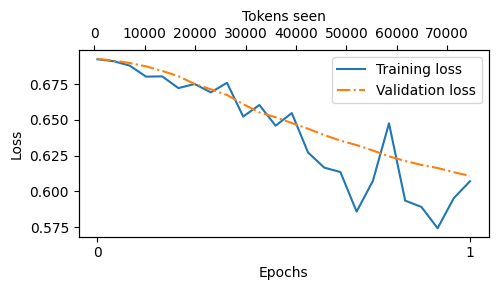

In [62]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

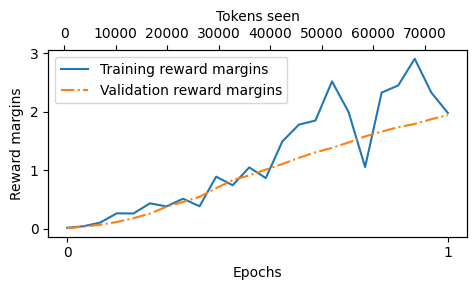

In [63]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="reward margins"
)